<a href="https://colab.research.google.com/github/dinhduy95/Data-structures-and-Algorithms/blob/master/AirBnB_NYC_2019_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = "Colab\ Notebooks/Airbnb\ dataset\ and\ models"

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content


**Our goal is to show the performance of 2 classifiers:**
- **Linear Regression**
- **Logistic Regression**

Let's get started!

In [2]:
!unzip "Airbnb dataset and models/archive.zip" 

Archive:  Airbnb dataset and models/archive.zip
  inflating: AB_NYC_2019.csv         
  inflating: New_York_City_.png      


In [3]:
!ls

 AB_NYC_2019.csv	      drive		   sample_data
'Airbnb dataset and models'   New_York_City_.png


In [4]:
# IMPORTS GALORE
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## The AirBnB NYC 2019 Dataset + EDA
The dataset contains information about AirBnB hosts in NYC from 2019. There are 49k unique hosts and 16 features for each.\
- **id:** listing ID
- **name:** name of the listing 
- **host_id:** host ID
- **neighbourhood_group:** NYC borough
- **neighbourhood:** neighbourhood
- **latitude:** latitude coordinates
- **longtitude:** longtitude coordinates
- **room_type:** listing space type (e.g., private room, entire home)
- **price:** price in dollars per night
- **minimum_nights:** number of minimum nights required for booking
- **number_of_reviews:** number of reviews
- **last_review:** date of the last review
- **reviews_per_month:** number of reviews per month
- **calculated_host_listing_count:** number of listings the host has
- **availability_365:** number of days the listing is available for booking

The goal is to predict the price of unseen housing units of being affordable or unaffordable by using their features.

In [5]:
df = pd.read_csv("AB_NYC_2019.csv") #, index_col=0)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### Building the training/validation/testing data 

In [6]:
df['price']

0        149
1        225
2        150
3         89
4         80
        ... 
48890     70
48891     40
48892    115
48893     55
48894     90
Name: price, Length: 48895, dtype: int64

We will assume that this task is for a particular client who has a specific budget and would like to simplify the problem by classifying any unit that costs \< $150 per night as 'affordable' and any unit that costs \$150 or great as 'unaffordable'.

In [7]:
df['affordable'] = np.where(df['price'] < 150, 1, 0)

In [8]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,affordable
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,1
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,1
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,1


The feature named `neighbourhood_group` can be confused with `neighbourhood`. So we can rename it to `borough`, as that is more distinct.

In [9]:
df.rename(columns={'neighbourhood_group': 'borough'}, inplace = True)

In [10]:
df.head()

,id,name,host_id,host_name,borough,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,affordable
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,1
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,1
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,1


In [11]:
df['price'].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

We can see `price` has a minimum value of \$0. 
This is unlikely to happen. So we remove any instance that has a price of $0.

In [12]:
print("Original training data: ", df.shape)

Original training data:  (48895, 17)


In [13]:
df = df.loc[df['price'] > 0]

In [14]:
print('New training size: ', df.shape)

New training size:  (48884, 17)


We split the data while ensuring our test set has a fair distribution of affordable units, then further split the training set so as to create validation set.

In [15]:
df['affordable'].value_counts()

1    31899
0    16985
Name: affordable, dtype: int64

In [16]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['affordable'])


In [17]:
df_train['affordable'].value_counts()

1    25519
0    13588
Name: affordable, dtype: int64

In [18]:
df_test['affordable'].value_counts()


1    6380
0    3397
Name: affordable, dtype: int64

In [19]:
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=99)

In [20]:
# ensure our dataset splits are of the % sizes we want
total_size = len(df_train) + len(df_val) + len(df_test)
print("train:", len(df_train), "=>", len(df_train) / total_size)
print("validation:", len(df_val), " =>", len(df_val) / total_size)
print("test:", len(df_test), "=>", len(df_test) / total_size)

train: 29330 => 0.5999918173635546
validation: 9777  => 0.20000409131822272
test: 9777 => 0.20000409131822272


Let's remove the target value (i.e., __affordable__) from the current dataframes and create it as separate prediction dataframe.

In [21]:
# training
x_train = df_train.drop(['price', 'affordable'], axis=1)
print(x_train.head())
y_train = pd.DataFrame(data=df_train['affordable'], columns=['affordable'])
y_train

             id                                               name    host_id host_name    borough    neighbourhood  latitude  longitude        room_type  minimum_nights  number_of_reviews last_review  reviews_per_month  calculated_host_listings_count  availability_365
451      158955                PRIVATE and SUNNY Williamsburg Apt!     465589      Amia   Brooklyn     Williamsburg  40.70867  -73.94284  Entire home/apt               2                385  2019-06-29               4.00                               1               222
9957    7662874                            Quiet, sunny, renovated   40223271       Max  Manhattan           Harlem  40.82883  -73.94468  Entire home/apt              15                 22  2019-05-05               0.49                               1                 0
34513  27369713    Welcome to NY :) new, clean and beautiful house  206260220    Idalia     Queens  Jackson Heights  40.75589  -73.85755     Private room               1                 38  

,affordable
451,1
9957,1
34513,1
22232,1
17503,1
...,...
7488,1
1056,1
23504,1
26833,1


In [22]:
# validation
x_val = df_val.drop(['price', 'affordable'], axis=1)
print(x_val.head())
y_val = pd.DataFrame(data=df_val['affordable'], columns=['affordable'])
y_val

             id                                          name    host_id                  host_name    borough     neighbourhood  latitude  longitude        room_type  minimum_nights  number_of_reviews last_review  reviews_per_month  calculated_host_listings_count  availability_365
14839  11753760              Gorgeous apartment in Brownstone   62542300                       Gary   Brooklyn       South Slope  40.66736  -73.98773     Private room               2                141  2019-07-05               3.63                               1               268
40808  31691209              All set for guys, don’t miss out   51596474                     Antony   Brooklyn         Gravesend  40.58453  -73.97172      Shared room               5                  5  2019-04-29               1.01                              12                 0
45014  34490379        Large Accessible Suite in Times Square  260639745  Manhattan At Times Square  Manhattan  Theater District  40.76251  -73.98392  

,affordable
14839,1
40808,1
45014,1
23786,0
47419,0
...,...
14799,0
13595,0
28646,0
13849,1


In [23]:
# test
x_test = df_test.drop(['price', 'affordable'], axis=1)
print(x_test.head())
y_test = pd.DataFrame(data=df_test['affordable'], columns=['affordable'])
y_test

             id                                               name    host_id        host_name    borough  neighbourhood  latitude  longitude        room_type  minimum_nights  number_of_reviews last_review  reviews_per_month  calculated_host_listings_count  availability_365
23393  18934106  JFK 10 & LGA 15 MINUTES  AC BEDROOM ATTCH BATH...   22959695  Gurpreet  Singh     Queens  Richmond Hill  40.69482  -73.82551     Private room               1                123  2018-08-14               4.85                               5                 0
16016  12954498                                    LOFT in Chelsea    1413546            Asher  Manhattan        Chelsea  40.74530  -73.99333  Entire home/apt              30                  1  2016-08-07               0.03                               2               236
20114  16108194             Quiet, Clean Room in Amazing Location!    2642093           Paloma   Brooklyn     Greenpoint  40.73124  -73.95527     Private room               5 

,affordable
23393,1
16016,0
20114,1
28507,1
34480,1
...,...
15056,1
40349,0
3570,1
1986,1


We will do EDA based on the training set `x_train` for the remaining part.

In [24]:
for col in x_train.columns:
    # print(col, ':', )
    print(col, ':', np.sum(x_train[col].isnull()))

id : 0
name : 12
host_id : 0
host_name : 12
borough : 0
neighbourhood : 0
latitude : 0
longitude : 0
room_type : 0
minimum_nights : 0
number_of_reviews : 0
last_review : 6065
reviews_per_month : 6065
calculated_host_listings_count : 0
availability_365 : 0


It's impossible to replace `last_review` and `reviews_per_month` with reasonable values. So let's ignore these two columns.

In [25]:
x_train = x_train.drop(['last_review', 'reviews_per_month'], axis=1)
x_val = x_val.drop(['last_review', 'reviews_per_month'], axis=1)
x_test = x_test.drop(['last_review', 'reviews_per_month'], axis=1)


Let's summarize statistics of the data

In [26]:
x_train.describe()

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,2.933000e+04,2.933000e+04,29330.000000,29330.000000,29330.000000,29330.000000,29330.000000,29330.000000
mean,1.899091e+07,6.746725e+07,40.729049,-73.952129,6.891647,23.490829,7.111081,113.047017
std,1.102972e+07,7.863754e+07,0.054446,0.046320,19.236816,45.324235,32.904893,131.845296
min,2.539000e+03,2.438000e+03,40.499790,-74.242850,1.000000,0.000000,1.000000,0.000000
25%,9.380684e+06,7.794212e+06,40.690423,-73.983130,1.000000,1.000000,1.000000,0.000000
50%,1.960499e+07,3.049924e+07,40.723090,-73.955630,3.000000,5.000000,1.000000,44.000000
75%,2.921518e+07,1.074344e+08,40.763067,-73.936100,5.000000,24.000000,2.000000,228.000000
max,3.648561e+07,2.743213e+08,40.913060,-73.712990,1000.000000,629.000000,327.000000,365.000000


In [27]:
x_train.shape

(29330, 13)

Let's look at maximum value of `minimum_nights` feature, which is 1000. It seems anomalous and wrong. If we assume our distribution of values is normally distributed. Standard deviation is 19,23 and two standard deviations of the mean would lead to 95% of the original data. Plot it as a histogram.

Text(0, 0.5, 'count')

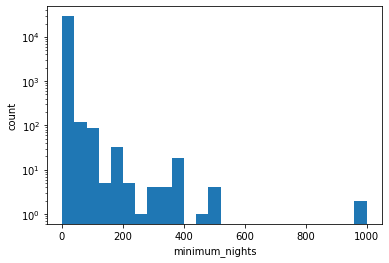

In [28]:
fig, ax = plt.subplots(1,1)
ax.hist(x_train['minimum_nights'], 25, log=True)
plt.xlabel('minimum_nights')
plt.ylabel('count')


Let's re-plot units with `mminimum_nights` < 365 days.

Text(0, 0.5, 'count')

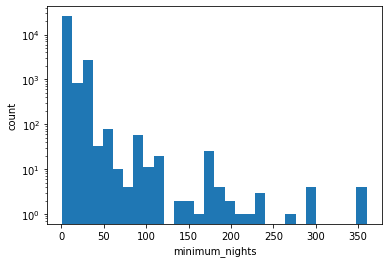

In [29]:
subset = x_train['minimum_nights']<365
fig, ax = plt.subplots(1,1)
ax.hist(x_train['minimum_nights'][subset], 30, log=True)
plt.xlabel('minimum_nights')
plt.ylabel('count')

Most units require < 30 days. So I think anything beyond 30 days could be suspicious. If we were to exclude any units that requires more than 30 days, how many instances would we be ignoring?

In [30]:
len(x_train.loc[x_train['minimum_nights'] > 30])

436

This is an ok amount of discard. Because we have a large amount of data remaining and entries beyond a 30-day-min could be unreliable.

In [31]:
good_subset = x_train['minimum_nights'] <= 30
x_train = x_train.loc[good_subset]
y_train = y_train.loc[good_subset]

Let's see the relationship of features. If any subplot of features depicts a linear relationship, then we can assume there exists some collinearity and that two features are not independent from each other.

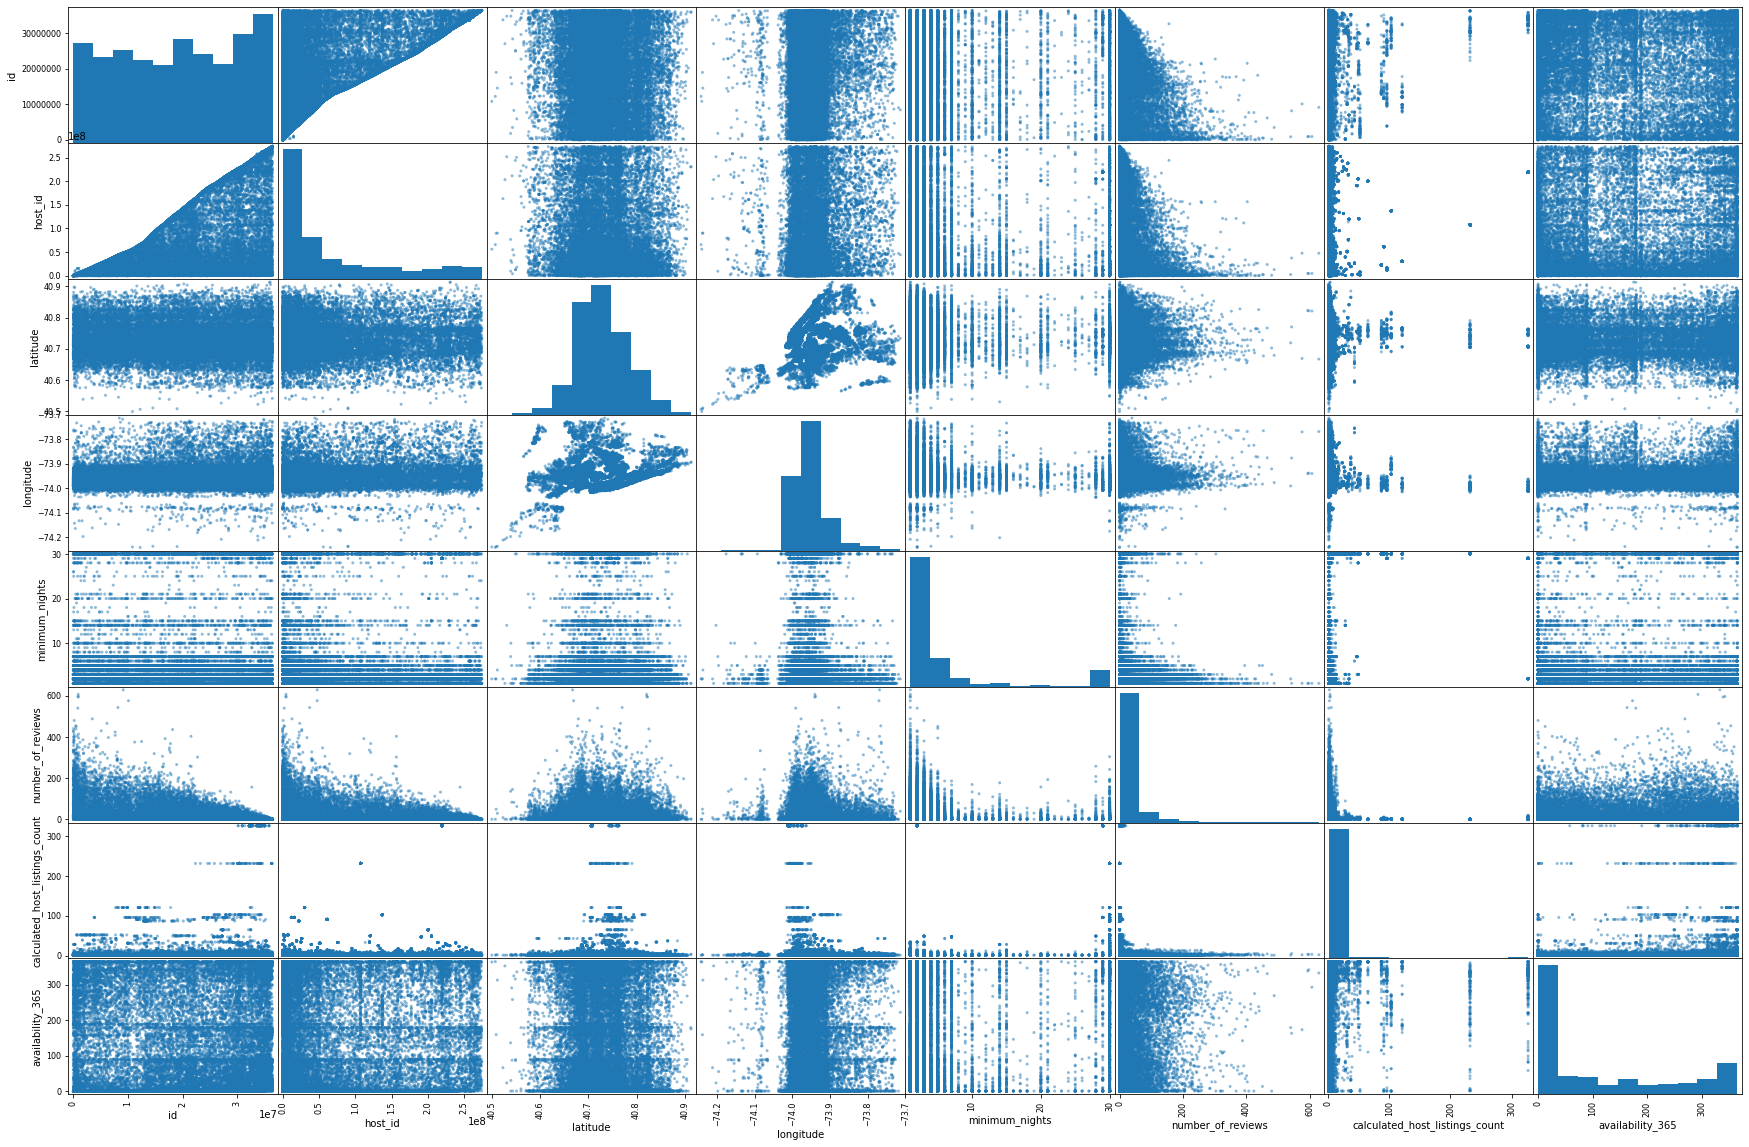

In [32]:
scatter_matrix(x_train, figsize=(30,20));


In [33]:
x_train

,id,name,host_id,host_name,borough,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
451,158955,PRIVATE and SUNNY Williamsburg Apt!,465589,Amia,Brooklyn,Williamsburg,40.70867,-73.94284,Entire home/apt,2,385,1,222
9957,7662874,"Quiet, sunny, renovated",40223271,Max,Manhattan,Harlem,40.82883,-73.94468,Entire home/apt,15,22,1,0
34513,27369713,"Welcome to NY :) new, clean and beautiful house",206260220,Idalia,Queens,Jackson Heights,40.75589,-73.85755,Private room,1,38,1,315
22232,17915565,1BR in the heart of UWS,80508435,Irving,Manhattan,Upper West Side,40.79416,-73.97044,Private room,1,26,2,0
17503,13770179,Cozy Private masterRoom 2 Blocks from Central ...,80794677,Yi,Manhattan,Upper West Side,40.79938,-73.96235,Private room,1,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7488,5590387,Village One Bedroom,20573060,Jenna,Manhattan,East Village,40.72566,-73.98032,Private room,2,16,1,18
1056,442636,"Private,Affordable, 20 min to NYC!",1655939,Joris,Queens,Ridgewood,40.70054,-73.90255,Entire home/apt,3,289,1,85
23504,19021031,Simple and clean bedroom with good view & light 2,70074907,Emily,Manhattan,Roosevelt Island,40.76870,-73.94308,Private room,1,0,2,0
26833,21287982,PERFECT LOCATION! EAST VILLAGE Private Room,117385673,Danielle,Manhattan,East Village,40.73030,-73.98341,Private room,3,1,2,0


In [34]:
x_train['borough'].value_counts()

Manhattan        12745
Brooklyn         11899
Queens            3388
Bronx              632
Staten Island      230
Name: borough, dtype: int64

## Predicting with Linear Regression
The model uses numeric values, not textual ones. Let's only use the following feature for our model.
- `borough`, using 1-hot encodings. There are 5 distinct boroughs, so represent them via 4 unique columns.
- `latitude`
- `longtitude`
- `room_type`, using 1-hot encodings. There are 3 types of room, so represent them via 2 unique columns. 
- `minimum_nights`
- `number_of_reviews`
- `calculated_host_listings_count`
- `availability_365`

In [35]:
x_train = pd.get_dummies(x_train, columns=['borough', 'room_type'], drop_first=True)
x_train = x_train.drop(['id', 'name', 'host_id', 'host_name', 'neighbourhood'], axis=1)

In [36]:
x_val = pd.get_dummies(x_val, columns=['borough', 'room_type'], drop_first=True)
x_val = x_val.drop(['id', 'name', 'host_id', 'host_name', 'neighbourhood'], axis=1)

x_test = pd.get_dummies(x_test, columns=['borough', 'room_type'], drop_first=True)
x_test = x_test.drop(['id', 'name', 'host_id', 'host_name', 'neighbourhood'], axis=1)

In [37]:
# training set
x_train_padded = sm.add_constant(x_train) # add a column of 1's as intercept
y_train_lr = y_train['affordable'].values.reshape(-1,1)

In [38]:
# Validation set
x_val_padded = sm.add_constant(x_val) # add a column of 1's as intercept
y_val_lr = y_val['affordable'].values.reshape(-1,1)

In [39]:
model = OLS(y_train_lr, x_train_padded)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     1422.
Date:                Fri, 23 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:32:02   Log-Likelihood:                -12826.
No. Observations:               28894   AIC:                         2.568e+04
Df Residuals:                   28881   BIC:                         2.579e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             96.8761      6.899     14.042      0.000      83.354     110.398
latitude                           0.5947      0.067      8.825      0.000       0.463       0.727
longitude                          1.6313      0.077     21.062      0.000       1.480       1.783
minimum_nights                     0.0052      0.000     17.194      0.000       0.005       0.006
number_of_reviews                  0.0008   5.08e-05     14.877      0.000       0.001       0.001
calculated_host_listings_count    -0.0007   7.39e-05     -9.368      0.000      -0.001      -0.001
availability_365                  -0.0004   1.85e-05    -23.768      0.000      -0.000      -0.000
borough_Brooklyn                   0.0728      0.019      3.828      0.000       0.036       0.110
borough_Manhattan                 -0.1229      0.017     -7.107      0.000      -0.157      -0.089
borough_Queens                    -0.0038      0.018     -0.209      0.835      -0.040       0.032
borough_Staten Island              0.4936      0.036     13.864      0.000       0.424       0.563
room_type_Private room             0.4636      0.005     99.360      0.000       0.454       0.473
room_type_Shared room              0.5049      0.015     34.059      0.000       0.476       0.534
==============================================================================
Omnibus:                      565.926   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              331.005
Skew:                          -0.093   Prob(JB):                     1.33e-72
Kurtosis:                       2.510   Cond. No.                     5.73e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
y_hat_val = results.predict(exog=x_val_padded)
y_hat_val

14839    0.897262
40808    0.938720
45014    0.632382
23786    0.499951
47419    0.223163
           ...   
14799    0.571139
13595    0.432485
28646    0.317985
13849    0.395181
29099    0.915415
Length: 9777, dtype: float64

In [41]:
# calculating and reporting the requested values, particularly the Test R^2
print('Train R^2 = {:.4}'.format(results.rsquared))
print('Test R^2 = {:.4}'.format(r2_score(y_val_lr, y_hat_val)))


Train R^2 = 0.3714
Test R^2 = 0.3


In [42]:
# let's use np.round() to check for values above 0.5, instead of manually checking it.
accuracy_score(y_val, np.round(y_hat_val))

0.7751866625754321

## Binary Logistic Regression

First, let's import the necessary classes:

In [43]:
from sklearn.linear_model import LogisticRegression


Let's instantiate a new LogisticRegression model.

In [44]:
lr = LogisticRegression()

Next, we fit our model

In [45]:
lr.fit(x_train, y_train['affordable'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
y_hat_val = lr.predict(x_val)
initial_score = accuracy_score(y_val['affordable'].to_numpy(), y_hat_val)
print("our initial logistic regression model yielded accuracy score of:", initial_score)


our initial logistic regression model yielded accuracy score of: 0.7779482458831952


In [47]:
best_accuracy = -1
best_model = None

# experiment with different values
c_vals = [1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
num_iters = [500, 1000, 5000, 10000]
for c_val in c_vals:
    for num_iter in num_iters:
        lr = LogisticRegression(C=c_val, solver='liblinear', max_iter=num_iter)
        lr.fit(x_train, y_train['affordable'])
        y_hat_val = lr.predict(x_val)
        cur_accuracy = accuracy_score(y_val['affordable'].to_numpy(), y_hat_val)

        if cur_accuracy > best_accuracy:
            best_accuracy = cur_accuracy
            best_model = lr

print('best logistic regression model:', best_model, 'yielded an accuracy score:', best_accuracy)
print('its learned coefficients:', len(best_model.coef_[0]))
print('the cofficients align with our features:', x_val.shape)

best logistic regression model: LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) yielded an accuracy score: 0.7741638539429273
its learned coefficients: 12
the cofficients align with our features: (9777, 12)


The result here shows that for this dataset logistic regression offered effectively identical performance as linear regression.

## Multiclass Classification
Let's construct five classes of pricing
- budget: < 80
- affordable: 80 < x < 120
- average: 120 < x < 180
- expensive: 180 < x < 240
- very expensive: 240 < x

In [48]:
# creates multi-class labels for training
x_train_multiclass = x_train.copy()
x_train_multiclass['price_level'] = pd.cut(df_train['price'],[0,80,120,180,240,float('inf')], labels=[0,1,2,3,4])
y_train_multiclass = pd.DataFrame(data=x_train_multiclass['price_level'], columns=["price_level"])
x_train_multiclass = x_train_multiclass.drop(['price_level'], axis=1)
x_train_multiclass

,latitude,longitude,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,room_type_Private room,room_type_Shared room
451,40.70867,-73.94284,2,385,1,222,1,0,0,0,0,0
9957,40.82883,-73.94468,15,22,1,0,0,1,0,0,0,0
34513,40.75589,-73.85755,1,38,1,315,0,0,1,0,1,0
22232,40.79416,-73.97044,1,26,2,0,0,1,0,0,1,0
17503,40.79938,-73.96235,1,4,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7488,40.72566,-73.98032,2,16,1,18,0,1,0,0,1,0
1056,40.70054,-73.90255,3,289,1,85,0,0,1,0,0,0
23504,40.76870,-73.94308,1,0,2,0,0,1,0,0,1,0
26833,40.73030,-73.98341,3,1,2,0,0,1,0,0,1,0


In [49]:
# creats multi-class labels for dev
x_val_multiclass = x_val.copy()
x_val_multiclass['price_level'] = pd.cut(df_val['price'],[0,80,120,180,240,float('inf')], labels=[0,1,2,3,4])
y_val_multiclass = pd.DataFrame(data=x_val_multiclass['price_level'], columns=["price_level"])
x_val_multiclass = x_val_multiclass.drop(['price_level'], axis=1)

In [50]:
best_accuracy = -1
best_model = None

# experiment with different values
c_vals = [1, 10, 100, 1000, 10000]
num_iters = [10, 100, 1000, 5000]
for c_val in c_vals:
    for num_iter in num_iters:
        lr = LogisticRegression(solver='lbfgs', max_iter=10000)
        lr.fit(x_train_multiclass, y_train_multiclass['price_level'])
        y_hat_val = lr.predict(x_val_multiclass)
        cur_accuracy = accuracy_score(y_val_multiclass['price_level'].to_numpy(), y_hat_val)
        print(cur_accuracy)
        if cur_accuracy > best_accuracy:
            best_accuracy = cur_accuracy
            best_model = lr

0.5117111588421807
0.5117111588421807
0.5117111588421807
0.5117111588421807
0.5117111588421807
0.5117111588421807
0.5117111588421807
0.5117111588421807
0.5117111588421807
0.5117111588421807
0.5117111588421807
0.5117111588421807
0.5117111588421807
0.5117111588421807
0.5117111588421807
0.5117111588421807
0.5117111588421807
0.5117111588421807
0.5117111588421807
0.5117111588421807


In [56]:
print("best logistic regression model:", best_model, "yielded an accuracy score:", best_accuracy)
print("its learned coefficients:", len(best_model.coef_[0]))
print("the coefficients align with our features:", x_val.shape)
for i in range(len(x_val.columns)):
    print("feature:", x_val.columns[i], "; coef:", best_model.coef_[0][i])


best logistic regression model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) yielded an accuracy score: 0.5117111588421807
its learned coefficients: 12
the coefficients align with our features: (9777, 12)
feature: latitude ; coef: 4.6848188491661995
feature: longitude ; coef: 2.5791935569795306
feature: minimum_nights ; coef: 0.04822664514747703
feature: number_of_reviews ; coef: 0.003461976142845079
feature: calculated_host_listings_count ; coef: -0.001966919598760019
feature: availability_365 ; coef: -0.0028317689514465332
feature: borough_Brooklyn ; coef: -0.6494913782542691
feature: borough_Manhattan ; coef: -2.45276657111893
feature: borough_Queens ; coef: -0.39379062586998437
feature: borough_Staten Is